In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [2]:
# Import the loading function of Scikit-Image
from skimage import io

## Loading the image and plotting it

By now you should be familiar with this part.

In [3]:
img = io.imread('face.jpg')

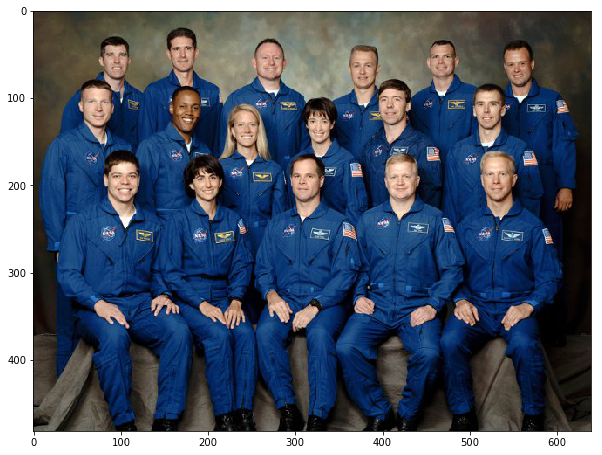

In [4]:
plt.figure(figsize=(10,10))
plt.imshow(img)

## Detecting faces

This subpart is heavily based on the tutorial of dlib http://dlib.net/face_detector.py.html

In [5]:
# Import the dlib library
import dlib
# Load the frontal face detector
detector = dlib.get_frontal_face_detector()

In [6]:
# Apply the detector to the img and return the detections (the '1' is a upsampling factor to get better results, not mandatory)
dets = detector(img, 1)
print("Number of faces detected: {}".format(len(dets)))

Number of faces detected: 17


`dets` is a special `dlib` structure which contains the detected rectangles

In [7]:
# Accessing the first detected face
dets[0]

rectangle(513,178,549,214)

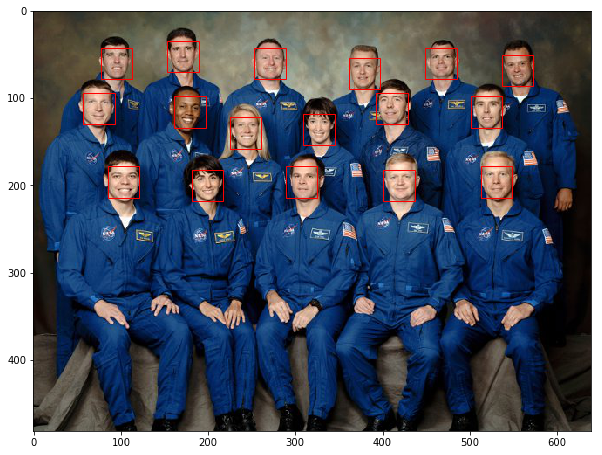

In [8]:
from matplotlib.patches import Rectangle
def draw_detection(det):
    # gca -> get-current-axis
    current_axis = plt.gca()
    # Add a rectangle on top of the image with the position defined by the detected face
    current_axis.add_patch(
                Rectangle(
                    (det.left(), det.top()),  # x, y
                    det.right() - det.left(), det.bottom() - det.top(),  # w, h
                    edgecolor="red", fill=False))
    
plt.figure(figsize=(10,10))
plt.imshow(img)
for det in dets:
    # For each detected face, draw it
    draw_detection(det)

From what you have learned in the first session, would you be able to crop the image to get the first detected face?

Remember that the image array (in numpy) is y-first, x-second

## Extracting a face descriptor

This part of the tutorial is based on http://dlib.net/face_recognition.py.html

In [9]:
# Shape predictor to refine the face detection result (find face landmarks like eye corners, mouth, etc...)
sp = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')
# Face recognition model
facerec = dlib.face_recognition_model_v1('dlib_face_recognition_resnet_model_v1.dat')

Loading the image and detecting the only face, you should be familiar about it by now

In [10]:
query_img = io.imread('query.jpg')

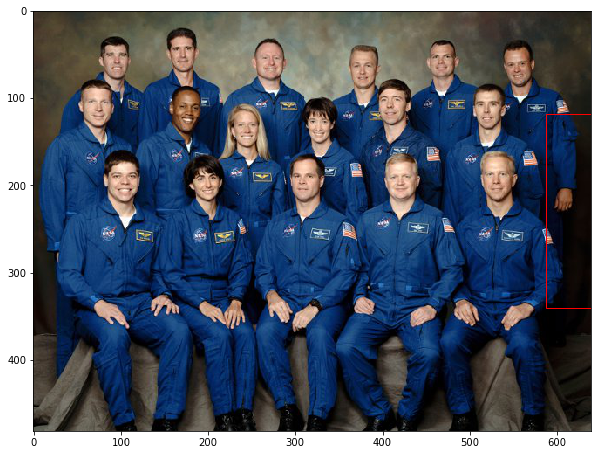

In [11]:
query_det = detector(query_img, 1)[0]

plt.figure(figsize=(10,10))
plt.imshow(img)
draw_detection(query_det)

In [12]:
# Get the landmarks/parts for the face in box d.
query_shape = sp(query_img, query_det)
# Extract the face descriptor
query_face_descriptor = facerec.compute_face_descriptor(query_img, query_shape)
query_face_descriptor = np.asarray(query_face_descriptor)  # Converting the descriptor to standard numpy array

We extracted a 128-D vector that represents the identity of the face. But for us it is just a list of numbers that does not tell us much.

In [13]:
print(query_face_descriptor.shape)
print(query_face_descriptor)

(128,)
[-0.23171096  0.15040471  0.04756611 -0.03589226 -0.1411279   0.11614099
 -0.02533896 -0.04316883  0.11729681 -0.07027651  0.13277642  0.07510576
 -0.21434264  0.02326302 -0.00301156  0.11333249 -0.14022852 -0.21320637
 -0.16787326 -0.09483351  0.04262779  0.05136522 -0.14008348  0.00126969
 -0.22149432 -0.26907825 -0.05485557 -0.0331854   0.02172627 -0.16125409
  0.0297067  -0.05624607 -0.18953468 -0.02414768  0.0506266   0.07730351
 -0.025716   -0.09172586  0.19145109  0.03834838 -0.13705458  0.07974249
  0.0955908   0.30337054  0.17318687  0.04682014 -0.02307204 -0.11095957
  0.19932733 -0.23648876  0.08872558  0.19486898  0.09924898  0.13572209
  0.1033664  -0.14607409  0.0324699   0.09968013 -0.14816684  0.04153293
  0.02619096  0.00159873 -0.0783112  -0.14155236  0.14140648  0.08647957
 -0.10780453 -0.15951663  0.1321457  -0.0939841  -0.09768043  0.01359921
 -0.10565324 -0.17666176 -0.20634346  0.12423237  0.44878215  0.20551017
 -0.29453972  0.01867042  0.00375122 -0.0725

## Face recognition

The face descriptor is not useful by itself, but it is a great tool to compare the facial identity between different photographs.

We have 10 faces of known personalities in the `faces` directory (you can browse the directory from the jupyter system), and we will try to compare them all with our query face.

In practice, an euclidean distance between 2 descriptors smaller than 0.6 usually means that the two descriptors are from the same person.

In [14]:
from glob import glob
from tqdm import tqdm  # For the eye-candy progress-bar

# List all the filenames in the faces directory
face_files = glob('faces/*')
face_files

['faces/may.png',
 'faces/trudeau.jpg',
 'faces/queen.jpg',
 'faces/putin.jpg',
 'faces/trump.jpg',
 'faces/macron.jpg',
 'faces/merkel.jpeg',
 'faces/trudeau_father.jpg',
 'faces/obama.jpg']

Processing: 100%|██████████| 9/9 [00:03<00:00,  3.12it/s]


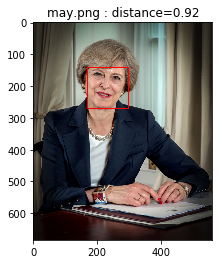

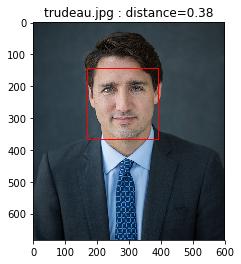

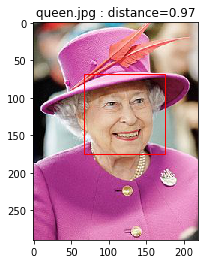

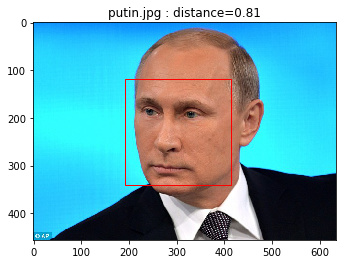

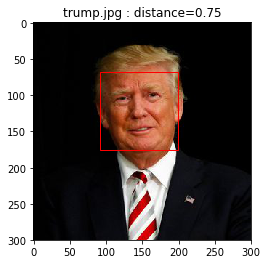

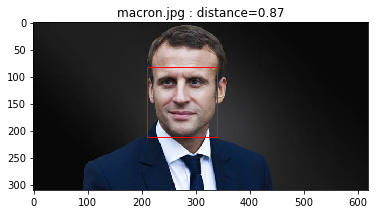

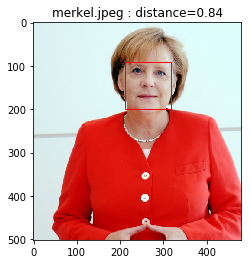

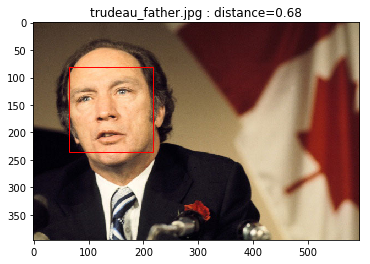

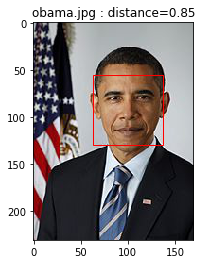

In [15]:
# For each file
for filename in tqdm(face_files, 'Processing'):
    # Read the image
    img = io.imread(filename)
    # Detect faces and take the first one
    det = detector(img, 1)[0]
    # Refine the face detection
    shape = sp(img, det)
    # Extract the face descriptor
    face_descriptor = np.asarray(facerec.compute_face_descriptor(img, shape))
    # Compute the euclidean distance between our query face descriptor and the current one
    dist = np.linalg.norm(query_face_descriptor-face_descriptor)
    # Plot the detection result
    plt.figure()
    plt.imshow(img)
    draw_detection(det)
    plt.title("{} : distance={:.2f}".format(filename.split('/')[-1], dist))

As you can see, despite the original image and the one in the 'face database' being quite different, the dlib library is quite confident about both of them coming from the same person.

Funny thing, the second closest face descriptor comes from his father...

In [16]:
# For the bored people, you could have a better look at the shape predictor that finds out the landmark on the face
# A good starting point is http://dlib.net/face_landmark_detection.py.html